<a href="https://colab.research.google.com/github/ganeshiimi/AV/blob/master/Janathahack_Ecommerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#https://datahack.analyticsvidhya.com/contest/janatahack-e-commerce-analytics-ml-hackathon/
import os
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import itertools

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
#evaluation metric
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir('/content/drive/My Drive/AV/Janathahack_Ecommerce')
train=pd.read_csv('train.csv',encoding= 'unicode_escape')
test=pd.read_csv('test.csv',encoding= 'unicode_escape')

train.head()

,session_id,startTime,endTime,ProductList,gender
0,u16159,15/12/14 18:11,15/12/14 18:12,A00002/B00003/C00006/D28435/;A00002/B00003/C00...,female
1,u10253,16/12/14 14:35,16/12/14 14:41,A00001/B00009/C00031/D29404/;A00001/B00009/C00...,male
2,u19037,01/12/14 15:58,01/12/14 15:58,A00002/B00001/C00020/D16944/,female
3,u14556,23/11/14 2:57,23/11/14 3:00,A00002/B00004/C00018/D10284/;A00002/B00004/C00...,female
4,u24295,17/12/14 16:44,17/12/14 16:46,A00001/B00001/C00012/D30805/;A00001/B00001/C00...,male


In [ ]:
print('shape train :{0},shape test : {1}'.format(train.shape,test.shape))
print('Duplicate entrees train: {0},Duplicate entrees test: {1}'.format(train.duplicated().sum(),test.duplicated().sum()))
print('null values train: {0},null values test: {1}'.format(train.isnull().sum()/train.shape[0],test.isnull().sum()/test.shape[0]))
print('same in train and test:',np.intersect1d(train.session_id, test.session_id))

shape train :(10500, 5),shape test : (4500, 4)
Duplicate entrees train: 0,Duplicate entrees test: 0
null values train: session_id     0.0
startTime      0.0
endTime        0.0
ProductList    0.0
gender         0.0
dtype: float64,null values test: session_id     0.0
startTime      0.0
endTime        0.0
ProductList    0.0
dtype: float64
same in train and test: []


In [ ]:
print(train['ProductList'][:1])
def data_transform(df):
  #train.assign(var1=train['ProductList'].str.split(';')).explode('ProductList').reset_index()
  #train.set_index(['session_id', 'startTime','endTime','gender']).apply(lambda x: x.str.split(';').explode()).reset_index()
  df['startTime'] = pd.to_datetime(df['startTime'], format='%d/%m/%y %H:%M')
  df['endTime'] = pd.to_datetime(df['endTime'], format='%d/%m/%y %H:%M')
  df['Duration'] = df['endTime'] - df['startTime'] 
  df['Duration'] = df['Duration'].astype('timedelta64[m]')
  df['Product_Count'] = df['ProductList'].apply(lambda x: len(x.split(";")))
  #df['month'] = df['endTime'].dt.strftime('%b')
  #df['week_day'] = df['endTime'].dt.weekday_name
  df['month'] = df['endTime'].dt.month
  df['year'] = df['endTime'].dt.year
  df['week_day'] = df['endTime'].dt.dayofweek

  s = df["ProductList"].str.split(';', expand=True).stack()
  i = s.index.get_level_values(0)
  df = df.loc[i].copy()
  df["ProductList"] = s.values

  df[['Cat1','Cat2','Cat3','Cat4','Cat5']] = df['ProductList'].str.split('/',expand=True)
  df.reset_index(drop=True,inplace=True)

  df=df.drop(['ProductList','Cat5','startTime','endTime'],axis=1)
  return(df) 


0    A00002/B00003/C00006/D28435/;A00002/B00003/C00...
Name: ProductList, dtype: object


In [ ]:
train=data_transform(train).copy(deep=True)
train['gender'].replace(['female','male' ],[0,1], inplace=True)

test=data_transform(test).copy(deep=True)

In [ ]:
print('shape train :{0},shape test : {1}'.format(train.shape,test.shape))
print('Duplicate entrees train: {0},Duplicate entrees test: {1}'.format(train.duplicated().sum(),test.duplicated().sum()))
print('null values train: {0},null values test: {1}'.format(train.isnull().sum()/train.shape[0],test.isnull().sum()/test.shape[0]))
print('in test and not in train:',np.setdiff1d(test.Cat1, train.Cat1))
print('in test and not in train:',np.setdiff1d(test.Cat2, train.Cat2))
print('in test and not in train:',np.setdiff1d(test.Cat3, train.Cat3))
print('in test and not in train:',np.setdiff1d(test.Cat4, train.Cat4))


shape train :(23251, 11),shape test : (10204, 10)
Duplicate entrees train: 0,Duplicate entrees test: 0
null values train: session_id       0.0
gender           0.0
Duration         0.0
Product_Count    0.0
month            0.0
year             0.0
week_day         0.0
Cat1             0.0
Cat2             0.0
Cat3             0.0
Cat4             0.0
dtype: float64,null values test: session_id       0.0
Duration         0.0
Product_Count    0.0
month            0.0
year             0.0
week_day         0.0
Cat1             0.0
Cat2             0.0
Cat3             0.0
Cat4             0.0
dtype: float64
in test and not in train: []
in test and not in train: ['B00088']
in test and not in train: ['C00084' 'C00121' 'C00168' 'C00172' 'C00188' 'C00203' 'C00236' 'C00262'
 'C00307' 'C00316' 'C00340' 'C00347' 'C00357' 'C00366' 'C00368' 'C00369'
 'C00380' 'C00408' 'C00417' 'C00422' 'C00431' 'C00438' 'C00439']
in test and not in train: ['D00026' 'D00031' 'D00032' ... 'D36081' 'D36082' 'D36085']


In [ ]:
def custom_round(x, base=10):
  temp=int(base * round(float(x)/base))
  return(temp)

train['Cat1_perc_male'] =100* (train.groupby('Cat1')['gender'].transform('sum') / train.groupby('Cat1')['gender'].transform('count'))
train['Cat1_perc_male'] =train['Cat1_perc_male'] .apply(lambda x: custom_round(x, base=10))
train['Cat2_perc_male'] =100* (train.groupby('Cat2')['gender'].transform('sum') / train.groupby('Cat2')['gender'].transform('count'))
train['Cat2_perc_male'] =train['Cat2_perc_male'] .apply(lambda x: custom_round(x, base=10))

train.head(5)


,session_id,gender,Duration,Product_Count,month,year,week_day,Cat1,Cat2,Cat3,Cat4,Cat1_perc_male,Cat2_perc_male
0,u16159,0,1.0,4,12,2014,0,A00002,B00003,C00006,D28435,10,10
1,u16159,0,1.0,4,12,2014,0,A00002,B00003,C00006,D02554,10,10
2,u16159,0,1.0,4,12,2014,0,A00002,B00003,C00006,D28436,10,10
3,u16159,0,1.0,4,12,2014,0,A00002,B00003,C00006,D28437,10,10
4,u10253,1,6.0,7,12,2014,1,A00001,B00009,C00031,D29404,80,80


In [ ]:
temp= train[['Cat1','Cat1_perc_male']].drop_duplicates()
test=pd.merge(test,temp,how='left',left_on='Cat1', right_on='Cat1')

temp= train[['Cat2','Cat2_perc_male']].drop_duplicates()
test=pd.merge(test,temp,how='left',left_on='Cat2', right_on='Cat2')

test.shape

(10204, 12)

In [ ]:
train=train.drop(['Cat1','Cat2','Cat3','Cat4','year'],axis=1)
test=test.drop(['Cat1','Cat2','Cat3','Cat4','year'],axis=1)
train=train.groupby('session_id').max().reset_index()
test=test.groupby('session_id').max().reset_index()

In [ ]:
train.head()

,session_id,gender,Duration,Product_Count,month,week_day,Cat1_perc_male,Cat2_perc_male
0,u10001,0,0.0,1,11,4,80,30
1,u10002,0,0.0,1,12,4,10,10
2,u10003,0,14.0,12,11,4,10,10
3,u10004,0,0.0,1,11,4,10,10
4,u10005,0,3.0,3,11,4,10,10


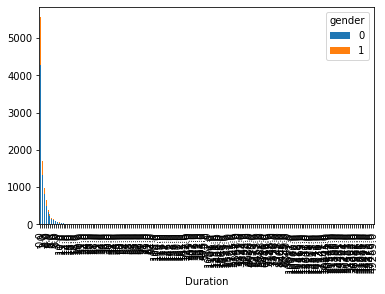

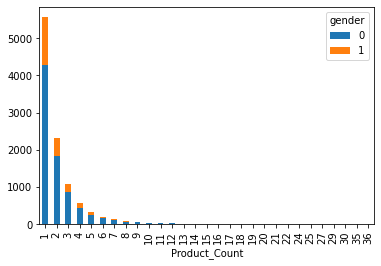

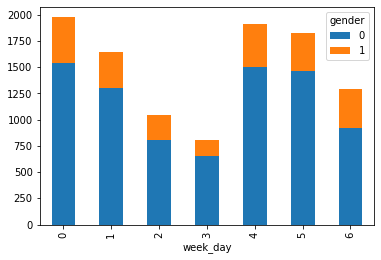

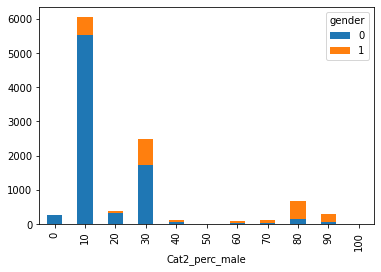

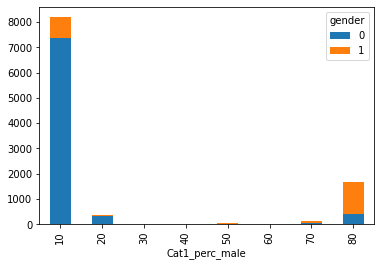

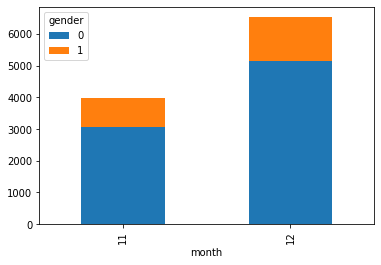

In [ ]:
k=list(train.columns)
k=list(set(k).difference(set(['session_id','gender'])))
y='gender'
top_n=5
for K in k:
    #tab=pd.crosstab(train[K],train[y],margins=True).sort_values('All',ascending=False)
    temp=train[['session_id',K,y]].drop_duplicates().reset_index(drop=True)
    tab=pd.crosstab(temp[K],temp[y],margins=True)

    tab = tab.drop('All',axis=1)
    tab = tab.drop('All',axis=0)
    tab[:].plot(kind='bar', stacked=True)
    #display(tab)
    plt.show()

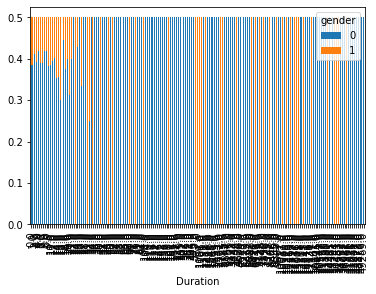

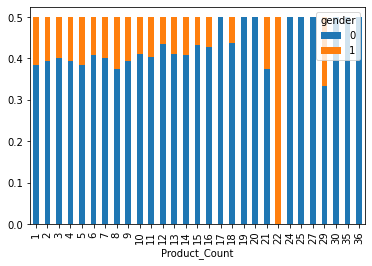

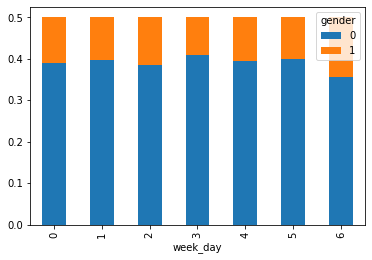

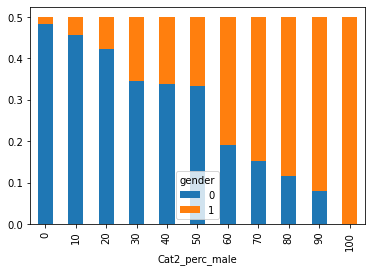

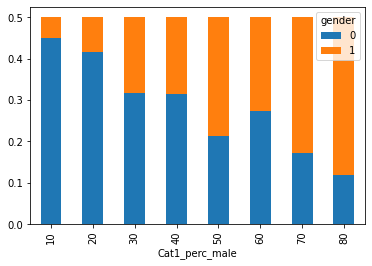

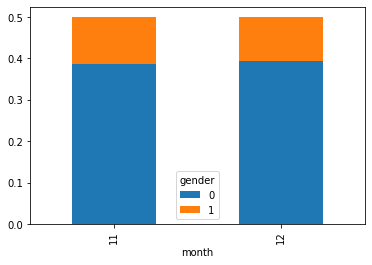

In [ ]:
top_n=5
for K in k:
    tab=pd.crosstab(train[K],train[y],margins=True).apply(lambda r: r/r.sum(), axis=1)
    tab = tab.drop('All',axis=1)
    tab = tab.drop('All',axis=0)
    tab[:].plot(kind='bar', stacked=True)
    plt.show()

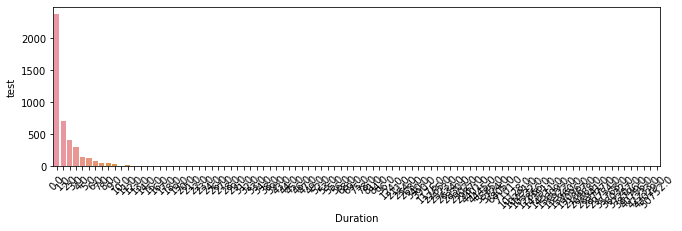

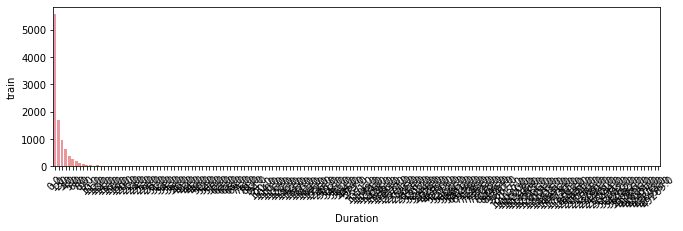

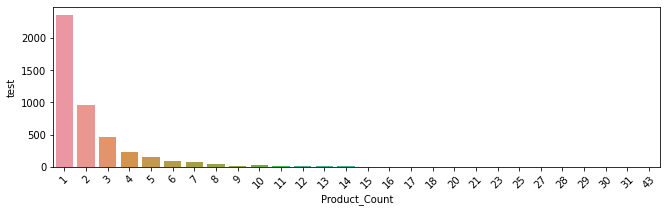

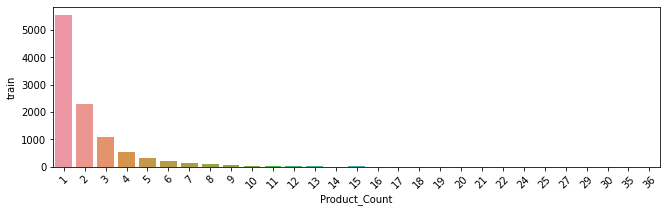

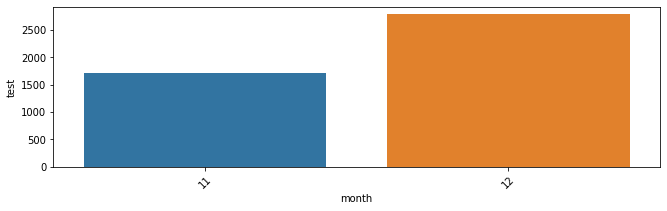

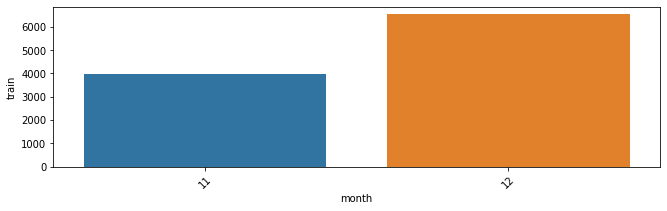

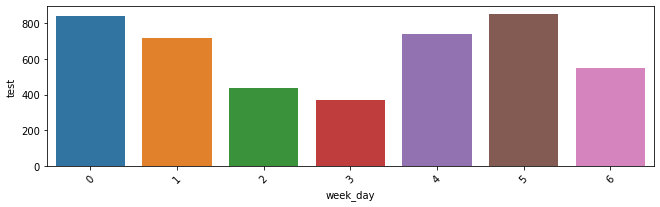

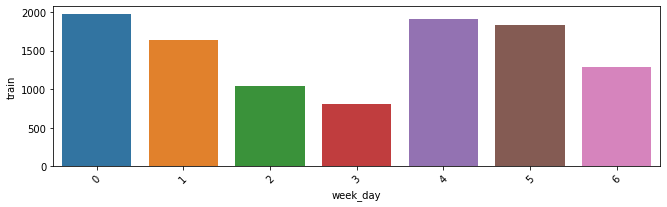

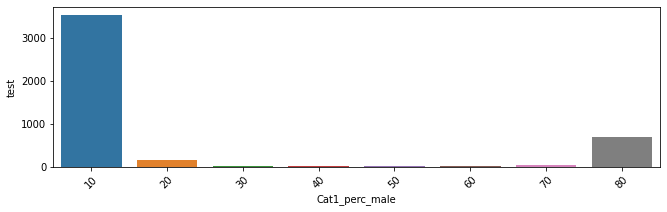

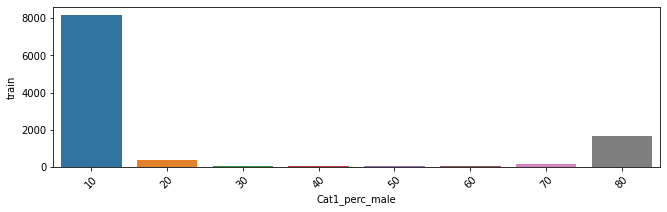

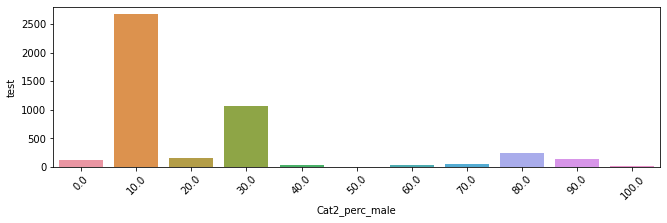

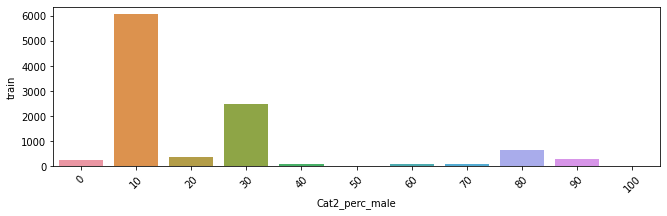

In [ ]:
#remove dependent varaible from list
k=list(train.columns)
k.remove('session_id')
y='gender'
k.remove(y)
for i,K in zip(range(len(k)),k):
    x=test[K].sort_values()
    fig1 = plt.figure(figsize=(50, 10))
    fig1=plt.subplot(3,4,i+1)
    ax1=sns.countplot(x)
    ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45)
    ax1.set(ylabel='test')
    
    y=train[K].sort_values()
    fig2 = plt.figure(figsize=(50, 10))
    fig2=plt.subplot(3,4,i+1)
    ax2=sns.countplot(y)
    ax2.set_xticklabels(ax2.get_xticklabels(),rotation=45)
    ax2.set(ylabel='train')

In [ ]:
#  def data_transform(df):
#    df_encoded = pd.get_dummies(df,prefix_sep='_',drop_first=True,prefix=['Cat1','Cat2','Cat3','Cat4'], columns=['Cat1','Cat2','Cat3','Cat4'])
#    df_encoded=df_encoded.groupby('session_id').max().reset_index()
#    return(df_encoded)

# train=data_transform(train).copy(deep=True)
# test=data_transform(test).copy(deep=True)

# print('shape train :{0},shape test : {1}'.format(train.shape,test.shape))


In [ ]:
print('null values train: {0},null values test: {1}'.format(train.isnull().sum()/train.shape[0],test.isnull().sum()/test.shape[0]))


null values train: session_id        0.0
gender            0.0
Duration          0.0
Product_Count     0.0
month             0.0
week_day          0.0
Cat1_perc_male    0.0
Cat2_perc_male    0.0
dtype: float64,null values test: session_id        0.000000
Duration          0.000000
Product_Count     0.000000
month             0.000000
week_day          0.000000
Cat1_perc_male    0.000000
Cat2_perc_male    0.000222
dtype: float64


In [ ]:
def missing_imputation(df,miss_base):
  Misisng_value_fields=['Cat2_perc_male']
  for col in Misisng_value_fields:
    df[col]=df.groupby(miss_base)[col].apply(lambda x:x.fillna(x.value_counts().index.tolist()[0]))
  return(df)  

test=missing_imputation(test,'month')
df_combined=pd.concat([train,test],axis=0,sort=False)
df_combined.reset_index(drop=True, inplace=True)
df_combined['product_per_duration']=df_combined['Product_Count']/(df_combined['Duration']+1)
df_combined['Total_basket_cat1_perc_male']=df_combined['Product_Count']*df_combined['Cat1_perc_male']/100
df_combined['Total_basket_cat2_perc_male']=df_combined['Product_Count']*df_combined['Cat2_perc_male']/100

In [ ]:
sub_id=test['session_id']
scaler = StandardScaler()

K = ['Duration','Product_Count','month','week_day','Cat1_perc_male','Cat2_perc_male','Total_basket_cat1_perc_male','Total_basket_cat2_perc_male'] 

for k in K:
  df_combined[[k]] = scaler.fit_transform(df_combined[[k]])

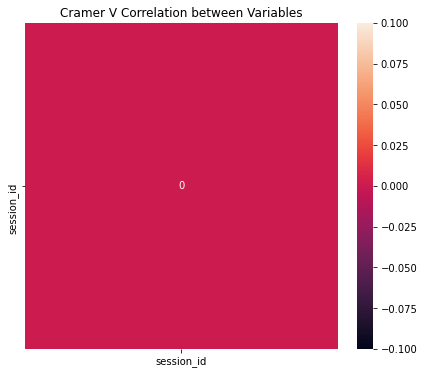

In [ ]:
def cramers_corrected_stat(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

cat_col = [c for i, c in enumerate(train.columns) if train.dtypes[i] in [np.object]]
corrM = np.zeros((len(cat_col),len(cat_col)))
for col1, col2 in itertools.combinations(cat_col, 2):
  idx1, idx2 = cat_col.index(col1), cat_col.index(col2)
  corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(train[col1], train[col2]))
  corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=cat_col, columns=cat_col)
fig, ax = plt.subplots(figsize=(7, 6))
ax = sns.heatmap(corr, annot=True, ax=ax); ax.set_title("Cramer V Correlation between Variables");


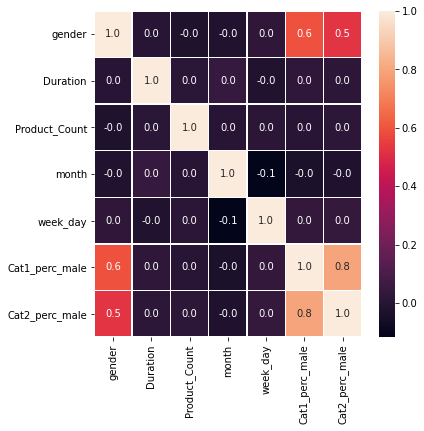

In [ ]:
Continuous_col = [c for i, c in enumerate(train.columns) if train.dtypes[i] in [np.int,np.float]]

f,ax=plt.subplots(figsize=(6,6))
sns.heatmap(train[Continuous_col].corr(),annot=True,linewidths=.5,fmt='.1f',ax=ax)

In [ ]:
train=df_combined[df_combined['gender'].notnull()]
test=df_combined[df_combined['gender'].isnull()]

In [ ]:
df_y=train['gender']
df_train_id=train['session_id']
df_test_id=test['session_id']

df_train=train.drop(['session_id','gender'], axis=1)
df_test=test.drop(['session_id','gender'], axis=1)

In [ ]:
def cv_score(ml_model, rstate = 11,cols = df_train.columns):
    i = 1
    cv_scores = []
    df1 = df_train.copy()
    df1 = df_train[cols]
    
    kf = KFold(n_splits=5,random_state=rstate,shuffle=True)
    for train_index,test_index in kf.split(df1,df_y):
      print('\n{} of kfold {}'.format(i,kf.n_splits))
      xtr,xvl = df1.loc[train_index],df1.loc[test_index]
      ytr,yvl = df_y[train_index],df_y[test_index]

      model = ml_model
      model.fit(xtr, ytr)
      
      train_val = model.predict(xtr)
      pred_val = model.predict(xvl)
      #RMSE
      #rmse_score_train = sqrt(mean_squared_error(ytr, train_val))
      #rmse_score = sqrt(mean_squared_error(yvl, pred_val))
      #F1 SCORE
      f1score=f1_score(yvl, pred_val,average='micro')
      #
      sufix = ""
      msg = ""
      #RMSE
      #msg += "Train RMSE: {:.5f} ".format(rmse_score_train)
      #msg += "Valid RMSE: {:.5f}".format(rmse_score)
      #F1 SCORE
      msg += "Valid F1 Score: {}".format(f1score)

      print("{}".format(msg))
      # Save scores
      #RMSE
      #cv_scores.append(rmse_score)
      #F1 SCORE
      cv_scores.append(f1score)
      i+=1

    return cv_scores

In [ ]:
logreg_scores = cv_score(LogisticRegression(solver='lbfgs'))



1 of kfold 5
Valid F1 Score: 0.8795238095238095

2 of kfold 5
Valid F1 Score: 0.8680952380952381

3 of kfold 5
Valid F1 Score: 0.8585714285714285

4 of kfold 5
Valid F1 Score: 0.8785714285714286

5 of kfold 5
Valid F1 Score: 0.8647619047619047


In [ ]:
dtree_scores = cv_score(DecisionTreeClassifier(min_samples_leaf=25, min_samples_split=25))


1 of kfold 5
Valid F1 Score: 0.8766666666666667

2 of kfold 5
Valid F1 Score: 0.861904761904762

3 of kfold 5
Valid F1 Score: 0.8538095238095238

4 of kfold 5
Valid F1 Score: 0.8766666666666667

5 of kfold 5
Valid F1 Score: 0.8657142857142858


In [ ]:
RF_scores = cv_score(RandomForestClassifier(n_estimators=100, max_depth=12))


1 of kfold 5
Valid F1 Score: 0.8738095238095238

2 of kfold 5
Valid F1 Score: 0.861904761904762

3 of kfold 5
Valid F1 Score: 0.8599999999999999

4 of kfold 5
Valid F1 Score: 0.8738095238095238

5 of kfold 5
Valid F1 Score: 0.8638095238095238


In [ ]:
XGBM_scores = cv_score(XGBClassifier(n_estimators=100, max_depth=12))


1 of kfold 5
Valid F1 Score: 0.8638095238095238

2 of kfold 5
Valid F1 Score: 0.8595238095238096

3 of kfold 5
Valid F1 Score: 0.8561904761904762

4 of kfold 5
Valid F1 Score: 0.87

5 of kfold 5
Valid F1 Score: 0.8576190476190476


In [ ]:
KNN_scores = cv_score(KNeighborsClassifier(n_neighbors=5))


1 of kfold 5
Valid F1 Score: 0.8519047619047619

2 of kfold 5
Valid F1 Score: 0.85

3 of kfold 5
Valid F1 Score: 0.8471428571428571

4 of kfold 5
Valid F1 Score: 0.8695238095238094

5 of kfold 5
Valid F1 Score: 0.8552380952380952


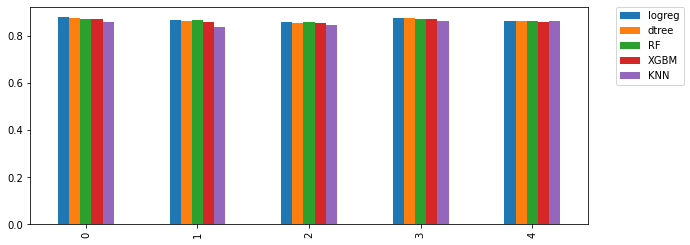

In [ ]:
results_df = pd.DataFrame({'logreg':logreg_scores, 'dtree': dtree_scores,'RF': RF_scores,'XGBM': XGBM_scores,'KNN': KNN_scores})
results_df.plot(y=["logreg", "dtree","RF","XGBM","KNN"], kind="bar",figsize=(10, 4), legend=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
model =XGBClassifier(random_state=101)
parameter_grid = {'max_depth' : [4,10,25],'n_estimators': [50,100,150]}
randomsearch = RandomizedSearchCV(estimator=model, param_distributions=parameter_grid, n_iter= 10, cv=5)
randomsearch.fit(df_train, df_y)
randomsearch.best_params_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


{'max_depth': 4, 'n_estimators': 50}

In [ ]:
#creating a decision tree instance with random search hyperparameters
model = XGBClassifier(random_state=101, n_estimators=50, max_depth=4)
model.fit(df_train, df_y)
pred=model.predict(df_test)
#clf.score(df_test, test_y)

In [ ]:
model =RandomForestClassifier(random_state=101)
parameter_grid = {'max_depth' : [5,8,9,10],'n_estimators': [40,45,50,55]}
randomsearch = RandomizedSearchCV(estimator=model, param_distributions=parameter_grid, n_iter= 10, cv=5)
randomsearch.fit(df_train, df_y)
randomsearch.best_params_


{'max_depth': 5, 'n_estimators': 40}

In [ ]:
#creating a decision tree instance with random search hyperparameters
model = RandomForestClassifier(random_state=101, n_estimators=40, max_depth=5)
model.fit(df_train, df_y)
pred=model.predict(df_test)
#clf.score(df_test, test_y)

Feature: 0, Score: 0.01169
Feature: 1, Score: 0.01194
Feature: 2, Score: 0.00203
Feature: 3, Score: 0.00724
Feature: 4, Score: 0.39930
Feature: 5, Score: 0.22865
Feature: 6, Score: 0.00665
Feature: 7, Score: 0.26907
Feature: 8, Score: 0.06343


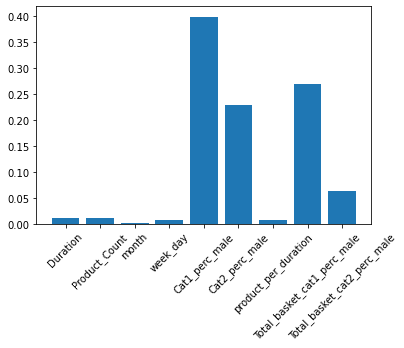

In [ ]:
# get importance
#feature_importance = model.coef_
#feature_importance = model.coef_[0]
#feature_importance = results.importances_mean
feature_importance=model.feature_importances_
# summarize feature importance
for i,v in enumerate(feature_importance):
  print('Feature: %0d, Score: %.5f' % (i,v))
  # plot feature importance
plt.bar(df_train.columns, feature_importance)
plt.xticks(rotation=45)
plt.show()

In [ ]:
sub = pd.DataFrame({'session_id': sub_id, 'gender': pred})
sub=sub.reindex(columns=["session_id","gender"])
sub['gender'].replace([ 0,1],['female','male'], inplace=True)
filename = 'submission_rf2.csv'
sub.to_csv(filename, index=False)